In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from itertools import combinations


In [17]:
config = {
    'epochs': 15,
    'batch_size': 64,
    'learning_rate': 0.001,
    'activation': tf.keras.activations.swish,
}

# Data Loader

In [ ]:
file_dir = './radar_data/rxtx-4-8/'
# training data
# input
mat = sio.loadmat(file_dir + 'train_Covariance.mat')
train_input = mat['Covariance']
train_input = np.float32(train_input)
# print("train_input shape:", train_input.shape)

# output
mat = sio.loadmat(file_dir + 'train_Label.mat')
train_output_old = mat['Label']
train_output_old = np.float32(train_output_old)
train_output = train_output_old

# # 8取2種可能改成28種單選
# train_output = np.zeros((train_output_old.shape[0], 28), dtype=np.float32)
# antenna_pairs = list(combinations(range(8), 2))  # [(0,1), (0,2), ..., (6,7)]
# for i, label in enumerate(train_output_old):
#     on_indices = np.where(label == 1)[0]  # 找出 1 的位置
    
#     # 在 combinations 裡找到此 pair 的 index
#     pair = tuple(on_indices)
#     if pair not in antenna_pairs:
#         print("Warning: Pair not found in antenna_pairs:", pair)
#     idx = antenna_pairs.index(pair)
#     train_output[i][idx] = 1  # 設定 one-hot 編碼

dataset = tf.data.Dataset.from_tensor_slices((train_input, train_output))
train_dataset = dataset.shuffle(buffer_size=train_input.shape[0]).batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

    
# print("train_output shape:", train_output.shape)
print("train_dataset.shape:", train_dataset.element_spec)


# testing data
# input
mat = sio.loadmat(file_dir + 'test_Covariance.mat')
test_input = mat['Covariance']
test_input = np.float32(test_input)
# print("test_input shape:", test_input.shape)

# output
mat = sio.loadmat(file_dir + 'test_Label.mat')
test_output_old = mat['Label']
test_output_old = np.float32(test_output_old)
test_output = test_output_old

# # 8取2種可能改成28種單選
# test_output = np.zeros((test_output_old.shape[0], 28), dtype=np.float32)
# for i, label in enumerate(test_output_old):
#     on_indices = np.where(label == 1)[0]  # 找出 1 的位置
    
#     # 在 combinations 裡找到此 pair 的 index
#     pair = tuple(on_indices)
#     if pair not in antenna_pairs:
#         print("Warning: Pair not found in antenna_pairs:", pair)
#     idx = antenna_pairs.index(pair)
#     test_output[i][idx] = 1  # 設定 one-hot 編碼

dataset = tf.data.Dataset.from_tensor_slices((test_input, test_output))
test_dataset = dataset.batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

# print("test_output shape:", test_output.shape)
print("test_dataset.shape:", test_dataset.element_spec)


train_dataset.shape: (TensorSpec(shape=(None, 18, 18, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))
test_dataset.shape: (TensorSpec(shape=(None, 18, 18, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))


In [19]:
# print("train_output[0]: ", train_output[0])

# model

In [ ]:
def residual_block(x, filters, use_pooling=False):
    shortcut = x

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # 如果shortcut維度不一樣，需要用1x1 conv調整
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    if use_pooling:
        x = layers.MaxPooling2D((2, 2))(x)
    
    return x


In [21]:
# input_layer = Input(shape=(train_input.shape[1], train_input.shape[2], 2))
# x = residual_block(input_layer, 64)
# x = residual_block(x, 64, use_pooling=True)
# # x = residual_block(x, 128)
# x = residual_block(x, 128, use_pooling=True)
# # x = residual_block(x, 512)
# x = residual_block(x, 512, use_pooling=True)

# x = layers.Flatten()(x)
# x = layers.Dense(512)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.25)(x)

# x = layers.Dense(512)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.25)(x)

# x = layers.Dense(256)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.25)(x)

# x = layers.Dense(train_output.shape[1])(x)
# # output_layer = layers.PReLU()(x)
# output_layer = layers.Activation('relu')(x)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()


In [22]:
model = keras.Sequential([
    keras.layers.Conv2D(128, (3, 3), input_shape=(train_input.shape[1], train_input.shape[2], 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(128, (3, 3), padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(256, (3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(256, (3, 3), padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(512, (3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(512, (3, 3), padding='same'),
    # keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(1024, (3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(1024, (3, 3), padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(1024, (3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(1024, (3, 3), padding='same'),
    # keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(config['activation']),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(train_output.shape[1]),
    # keras.layers.LeakyReLU(alpha=1.5)
    keras.layers.PReLU(),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       2432      
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 16, 16, 128)       0         
                                                                 
 dropout_13 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

In [23]:
def exact_match_accuracy(y_true, y_pred):
    # 對 y_pred 套用 sigmoid
    y_pred = tf.keras.activations.sigmoid(y_pred)
    
    # 轉為布林值：大於 0.5 算正類
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)

    # 比對是否逐 row 全部正確
    match = tf.reduce_all(tf.equal(y_true, y_pred_binary), axis=1)

    # 計算準確率
    accuracy = tf.reduce_mean(tf.cast(match, tf.float32))
    
    return accuracy

def top2_exact_match_accuracy(y_true, y_pred):
    # 將預測值與真實值的前兩個最大值的 index 取出
    pred_top2 = tf.math.top_k(y_pred, k=2).indices  # [batch_size, 2]
    true_top2 = tf.math.top_k(y_true, k=2).indices  # [batch_size, 2]

    # 排序（不考慮順序，只看兩個 index 是否一致）
    pred_top2_sorted = tf.sort(pred_top2, axis=1)
    true_top2_sorted = tf.sort(true_top2, axis=1)

    # 每一筆樣本是否完全相同
    exact_match = tf.reduce_all(tf.equal(pred_top2_sorted, true_top2_sorted), axis=1)  # [batch_size]

    # 計算平均準確率
    return tf.reduce_mean(tf.cast(exact_match, tf.float32))

In [24]:
def combination_loss(lambda_constraint=5):
    def loss_fn(y_true, y_pred):
        # 二進制交叉熵損失
        # bce_loss = keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        bce_loss = tf.reduce_mean(keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True))
        
        # 約束：只有兩個正數
        probs = keras.activations.sigmoid(y_pred)
        # positive_count = tf.reduce_sum(probs, axis=1)
        positive_count = tf.reduce_sum(tf.cast(probs > 0.5, tf.float32), axis=1)  # 每行正數的個數
        sum_constraint = tf.reduce_mean(tf.square(positive_count - 2.0))  # 平均每行正數個數與2的差的平方
        # sum_constraint = tf.reduce_mean(tf.square(tf.reduce_sum(y_pred, axis=1) - 2.0))
        
        # 總損失
        total_loss = bce_loss + lambda_constraint * sum_constraint
        return total_loss
    
    return loss_fn

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate']),
              # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              # loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss = combination_loss(),
              metrics = [exact_match_accuracy])

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-9
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_exact_match_accuracy', patience=5, restore_best_weights=True
)

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=config['epochs'], batch_size=config['batch_size'], callbacks=[lr_scheduler, early_stopping])

Epoch 1/15
896/896 [==============================] - 35s 37ms/step - loss: 0.5352 - exact_match_accuracy: 0.0151 - val_loss: 0.5402 - val_exact_match_accuracy: 0.0429 - lr: 0.0010
Epoch 2/15
896/896 [==============================] - 33s 37ms/step - loss: 0.3508 - exact_match_accuracy: 0.1559 - val_loss: 0.5407 - val_exact_match_accuracy: 0.1409 - lr: 0.0010
Epoch 3/15
896/896 [==============================] - 33s 37ms/step - loss: 0.2297 - exact_match_accuracy: 0.4544 - val_loss: 0.6909 - val_exact_match_accuracy: 0.2254 - lr: 0.0010
Epoch 4/15
896/896 [==============================] - 33s 37ms/step - loss: 0.1388 - exact_match_accuracy: 0.7057 - val_loss: 0.7247 - val_exact_match_accuracy: 0.2565 - lr: 5.0000e-04
Epoch 5/15
896/896 [==============================] - 33s 37ms/step - loss: 0.1005 - exact_match_accuracy: 0.8018 - val_loss: 0.8033 - val_exact_match_accuracy: 0.2567 - lr: 5.0000e-04
Epoch 6/15
896/896 [==============================] - 33s 37ms/step - loss: 0.0658 - ex

# Training result

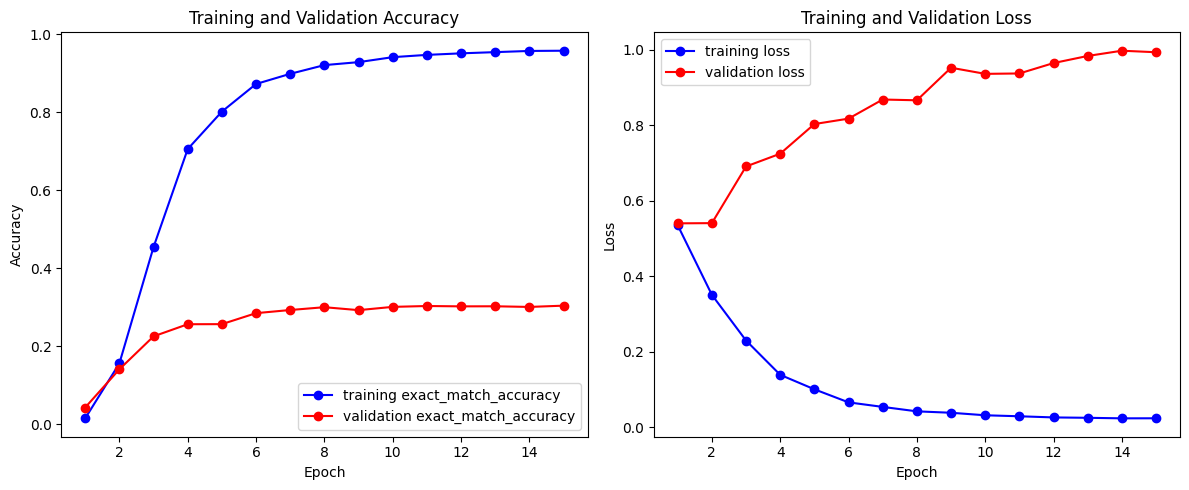

In [27]:

# 取出歷史紀錄
acc = history.history['exact_match_accuracy']
val_acc = history.history['val_exact_match_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# 畫準確率
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='training exact_match_accuracy')
plt.plot(epochs, val_acc, 'ro-', label='validation exact_match_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 畫損失
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'ro-', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test

In [28]:
model.evaluate(test_dataset, verbose=1)

224/224 [==============================] - 2s 10ms/step - loss: 0.9935 - exact_match_accuracy: 0.3041


[0.9935478568077087, 0.3041294515132904]

In [ ]:
predictions = model.predict(test_input)
# print('\nPredictions shape:', predictions.shape)
predictions = keras.layers.Activation('sigmoid')(predictions)  # 將輸出轉換為概率
predictions = (predictions > 0.5).numpy().astype(np.float32)  # 將概率轉換為二進制輸出
# print('predictions:', predictions[0:10])  # 顯示前10筆預測結果

sum_is_not_2_cnt = 0
accuracy = 0
for pred, label in zip(predictions, test_output):
    # print('Predicted:', pred, 'True:', label)
    accuracy += (pred == label).all()
    if np.sum(pred) != 2:
        sum_is_not_2_cnt += 1
        
accuracy /= len(predictions)
print('\nExact Match Accuracy:', accuracy)
print('Number of predictions not summing to 2:', sum_is_not_2_cnt)
print('Number of prediction summing to 2 ratio:', (len(predictions) - sum_is_not_2_cnt) / len(predictions))

# pred_top2 = tf.math.top_k(predictions, k=2).indices  # [batch_size, 2]
# true_top2 = tf.math.top_k(test_output, k=2).indices  # [batch_size, 2]

# # 排序（不考慮順序，只看兩個 index 是否一致）
# pred_top2_sorted = tf.sort(pred_top2, axis=1)
# true_top2_sorted = tf.sort(true_top2, axis=1)

# # 每一筆樣本是否完全相同
# exact_match = tf.reduce_all(tf.equal(pred_top2_sorted, true_top2_sorted), axis=1)  # [batch_size]
# # print('Predicted Top-2 Indices:', pred_top2_sorted.numpy())
# # print('True Top-2 Indices:', true_top2_sorted.numpy())

# # 計算平均準確率
# accuracy = tf.reduce_mean(tf.cast(exact_match, tf.float32))
# print('\nTop-2 Exact Match Accuracy:', accuracy.numpy())


448/448 [==============================] - 4s 8ms/step
Predicted: [0. 1. 1. 0. 0. 0. 0. 0.] True: [0. 0. 0. 0. 0. 1. 1. 0.]
Predicted: [1. 0. 0. 0. 0. 0. 1. 0.] True: [1. 0. 1. 0. 0. 0. 0. 0.]
Predicted: [0. 0. 0. 1. 0. 1. 0. 0.] True: [0. 0. 0. 1. 0. 1. 0. 0.]
Predicted: [1. 1. 0. 0. 0. 0. 0. 0.] True: [1. 0. 0. 0. 0. 1. 0. 0.]
Predicted: [1. 0. 0. 0. 0. 0. 0. 0.] True: [0. 0. 0. 1. 1. 0. 0. 0.]
Predicted: [1. 0. 0. 1. 0. 0. 0. 0.] True: [0. 0. 0. 1. 1. 0. 0. 0.]
Predicted: [1. 0. 0. 0. 0. 0. 0. 1.] True: [0. 0. 0. 1. 1. 0. 0. 0.]
Predicted: [0. 0. 0. 0. 1. 0. 0. 1.] True: [0. 0. 0. 1. 1. 0. 0. 0.]
Predicted: [1. 1. 0. 0. 0. 1. 0. 0.] True: [0. 1. 0. 0. 0. 1. 0. 0.]
Predicted: [0. 0. 0. 0. 0. 0. 1. 0.] True: [0. 0. 0. 1. 0. 0. 1. 0.]
Predicted: [1. 0. 0. 0. 1. 0. 0. 0.] True: [1. 0. 0. 0. 1. 0. 0. 0.]
Predicted: [0. 0. 1. 0. 1. 0. 0. 0.] True: [1. 0. 0. 0. 0. 0. 1. 0.]
Predicted: [1. 0. 0. 0. 0. 0. 1. 0.] True: [1. 0. 0. 0. 0. 0. 1. 0.]
Predicted: [1. 0. 0. 1. 0. 0. 0. 0.] True: [1. 0

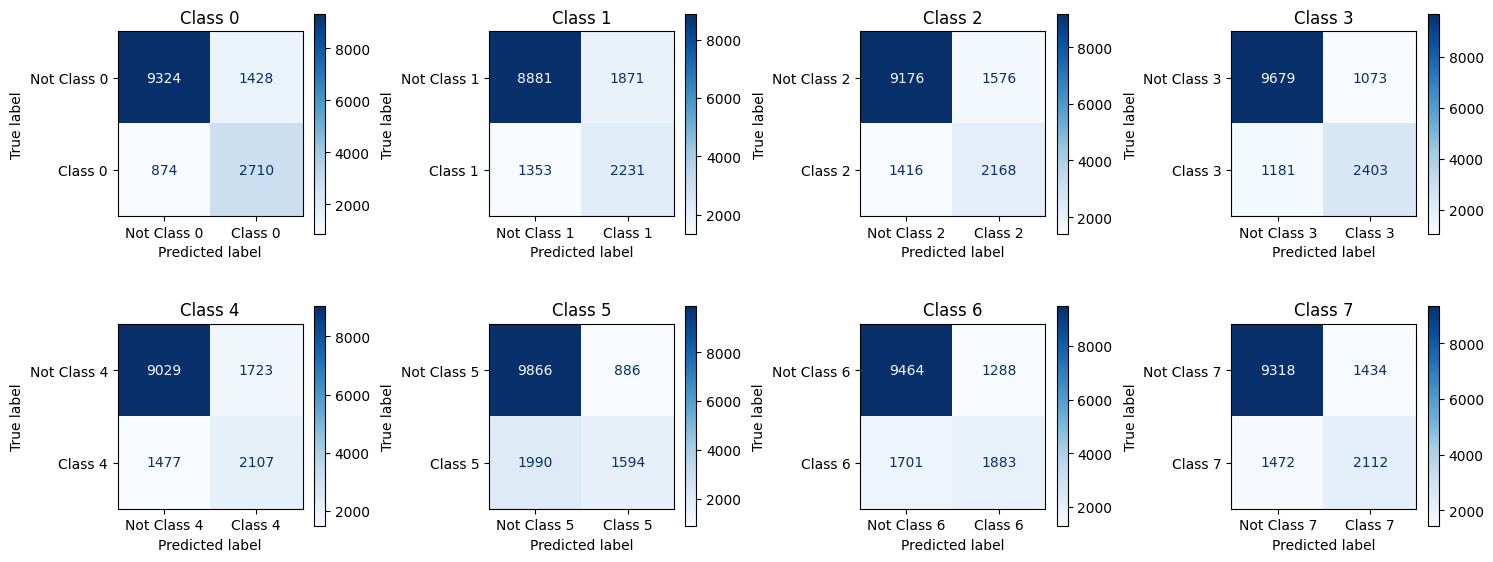

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# y_true, y_pred 是多標籤格式，例如：
# y_true = np.array([[1, 0, 0, 1, 0, 0, 0, 0], [...], ...])
# y_pred = np.array([[1, 0, 1, 0, 0, 0, 0, 0], [...], ...])

# 計算每個類別的混淆矩陣
cm = multilabel_confusion_matrix(test_output, predictions)

# 類別名稱（可以自己命名）
class_names = [f"Class {i}" for i in range(test_output.shape[1])]

# 畫出每個類別的混淆矩陣
fig, axes = plt.subplots(2, (len(class_names)+1)//2, figsize=(15, 6))
axes = axes.ravel()

for i in range(len(class_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i],
                                   display_labels=["Not "+class_names[i], class_names[i]])
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    axes[i].set_title(class_names[i])

plt.tight_layout()
plt.show()
